# 1. PARAMETERS

In [1]:
####### CONFIGURATION

class CFG:

    # environment
    environment  = 'local'  # work environment ['kaggle', 'local']
    device       = 'GPU'    # training device ['GPU', 'TPU']
    device_index = 1        # device index (when using single device)
    num_devices  = 1        # no. GPU/TPU devices (modeling)
    cpu_workers  = 4        # no. CPU cores (data loading)

    # general
    version  = 69     # notebook version (for saving outputs)
    debug    = False  # debug mode runs 10 batches for 3 epochs
    tracking = True   # track results using neptune.ai
    seed     = 10627  # random state

    # data
    num_folds   = 5      # no. CV folds
    num_cuts    = 12     # no. target cuts for stratified split
    num_reps    = 3      # no. repititions of CV
    data_pl     = False  # False or percentage of appended pseudo-labeled data 
    max_len     = 256    # maximum sequence length 
    dynamic_pad = False  # whether to enable dynamic padding on batch level
    
    # augmentations
    p_shuffle   = 0.05  # probability of batch-level sentence shuffle
    noise_alpha = 0     # magnitude of noise in targets based on SD
    p_translate = 0     # probability of swapping a sentence with backtranslation
    
    # architecture
    backbone       = 'bert-base-uncased'  # transformer backbone   
    hidden_size    = 768                  # size of the hidden layer
    pretrained     = True                 # pretrained weights [False, True, path]
    freeze_embed   = True                 # whether to freeze the embedding layer
    freeze_layers  = 0                    # how many deep transformer layers to freeze
    init_range     = None                 # weight init range for new layers (None or float)
    hidden_dropout = 0.0                  # dropout probability on hidden layers

    # network head
    pooling        = 'mean'  # pooling technique ['default', 'cls', 'mean', 'max', 'meanmax']
    pooling_layer  = -1      # hidden layer to perform pooling
    concat_layers  = 3       # no. concatenated pooling layers starting from pooling_layer
    layer_norm_eps = 1e-7    # layer normalization epsilon
    head_dropout   = 0.0     # dropout probability in head
    
    # training
    num_epochs    = 5      # no. epochs per fold
    batch_size    = 20     # no. images per batch 
    accum_iter    = 1      # no. batches for gradient accumalation
    grad_clip     = False  # max gradient norm (False or float)
    use_fp16      = True   # mixed precision mode 
    max_batches   = False  # max no. batches per training epoch (False or int)
    batch_verbose = False  # print loss every n batches
    
    # learning rate 
    lr             = 1e-4  # starting learning rate
    decay          = 1e-3  # weight decay of optimizer (L2 regularization)
    lr_layer_decay = 0.85  # LR multiplier when going to deeper layers

    # optimizer & scheduler
    optim           = 'AdamW'   # LR optimizer ['Adam', 'AdamW', 'AdamP', 'madgrad']
    adamw_bias      = True      # AdamW param: whether to enable bias correction
    scheduler       = 'cosine'  # LR scheduler after warmup ['constant', 'linear', 'cosine']
    warmup          = 0.5         # no. epochs for warmup
    update_on_batch = True      # update LR after every batch (or epoch)
    
    # loss function
    loss_fn = 'MSE'  # loss ['MSE', 'RMSE']

    # stochastic weight averaging
    swa               = False     
    swa_start         = 5
    swa_learning_rate = 1e-4
    anneal_epochs     = 3 
    anneal_strategy   = 'cos'
    
    # inference
    eval_step        = 4     # no. batches before evaluation (False or int)
    predict_oof      = True  # whether to produce OOF predictions
    predict_test     = True  # whether to produce test predictions 
    valid_batch_size = 128   # no. cases per batch 

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

In [3]:
####### UPDATES FOR DEBUG MODE

if CFG['debug']:
    CFG['predict_test'] = False
    CFG['tracking']     = False
    CFG['num_epochs']   = 2
    CFG['num_folds']    = 2
    CFG['num_reps']     = 1

# 2. PREPARATIONS

In [4]:
####### PACKAGES

if CFG['environment'] != 'local':
    !pip install timm transformers accelerate adamp madgrad
    !pip install --upgrade neptune-client
    !pip install --upgrade --force-reinstall --no-deps -q kaggle
    
if CFG['device'] == 'TPU':
    !pip install cloud-tpu-client==0.10 'https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl'

import numpy as np
import pandas as pd

import torch

import os
import sys
import time
import pickle

from tqdm.auto import tqdm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from accelerate import notebook_launcher

import warnings
import gc; gc.enable()

In [5]:
####### MODULES

# source
if CFG['environment'] == 'local':
    sys.path.append('../code')  
elif CFG['environment'] == 'kaggle':
    sys.path.append('../input/readability-code')  

# utilities
from utilities import *

# training and inference
from run_training import run_training
from run_inference import run_inference

# visualiztion
from sample_batch import sample_batch

In [6]:
####### WORKING PATHS

if CFG['environment'] == 'local':
    CFG['data_path']  = '../input/'
    CFG['out_path']   = '../output/v' + str(CFG['version']) + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])
        
elif CFG['environment'] == 'kaggle':
    CFG['data_path']  = '../input/commonlitreadabilityprize/'
    CFG['out_path']   = ''

In [7]:
####### TRACKING WITH NEPTUNE

if CFG['tracking']:
    import neptune 
    neptune.init(api_token = 'you-api-token',
                 project_qualified_name = 'your-project')
    neptune.create_experiment(name = 'v' + str(CFG['version']), params = CFG) 

https://app.neptune.ai/ml_comps/readability/e/READ-485


In [8]:
####### SETTINGS

warnings.filterwarnings('ignore')       # ignoring warnings
pd.options.display.max_columns = 100    # maximum displayed columns
torch.backends.cudnn.benchmark = False  # set to True if NN inputs are the same size
seed_everything(CFG['seed'])            # random seed

- setting random seed to 10627...


# 3. DATA PREP

In [9]:
####### TRAIN DATA PROCESSING

# import
df = pd.read_csv(CFG['data_path'] + 'train.csv')

# check max length
from tokenizer import get_tokenizer
tokenizer = get_tokenizer(CFG)
df['seq_length'] = df['excerpt'].apply(lambda x: len(tokenizer(x)['input_ids']))
print('maximum length: {}'.format(max(df['seq_length'])))

# partitioning
df['target_cat'] = pd.cut(df['target'], CFG['num_cuts'], labels = False)
for i in range(CFG['num_reps']):
    folds = StratifiedKFold(n_splits = CFG['num_folds'], shuffle = True, random_state = CFG['seed'] - i)
    for fold_idx, (trn_idx, val_idx) in enumerate(folds.split(df, df['target_cat'])):
        df.loc[val_idx, 'fold' + str(i)] = int(fold_idx)
    df['fold' + str(i)] = df['fold' + str(i)].astype(int)
             
# display
print('train shape: {}'.format(df.shape))
display(df.head())

maximum length: 314
train shape: (2834, 11)


,id,url_legal,license,excerpt,target,standard_error,seq_length,target_cat,fold0,fold1,fold2
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,220,7,1,3,1
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,243,7,0,3,1
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,229,6,4,0,3
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,220,5,3,2,0
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,186,8,1,2,2


In [10]:
####### TEST DATA PROCESSING

# import
sub = pd.read_csv(CFG['data_path'] + 'test.csv')

# subset if debug
if CFG['debug']:
    sub = sub.head(CFG['valid_batch_size'])

# display
print('test shape: {}'.format(sub.shape))
display(sub.head())

test shape: (7, 4)


,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [11]:
###### SHOW SAMPLE BATCH

_ = sample_batch(CFG, df, sample_size = 5, seq_size = 15, batch_idx = 2)

- setting random seed to 10627...
- loading time: 0.1100 vs 0.1077 seconds
- inputs shape: torch.Size([5, 256]) vs torch.Size([5, 256])
----------------------------------------------------------------------------------------------------
101, 5916, 15983, 2001, 2908, 1010, 10508, 2001, 2908, 1012, 1996, 2282, 2001, 3243, 4064 |           -3.081337118
101, 2009, 2001, 3373, 2011, 1996, 4054, 2273, 1997, 3448, 2008, 14838, 1005, 1055, 25353 |           -2.145248365
101, 1996, 5119, 1999, 1037, 3518, 2277, 4930, 1996, 3178, 1997, 2048, 1012, 1996, 2181 |           -1.400318025
101, 1996, 3750, 2939, 12531, 2039, 1998, 2091, 1996, 2146, 1010, 2659, 1011, 8292, 18450 |           -0.495298635
101, 2023, 21877, 7265, 4360, 2015, 2001, 10920, 1011, 2048, 2086, 2214, 1012, 2002, 2001 |            0.245805709
----------------------------------------------------------------------------------------------------
[CLS] it was believed by the principal men of virginia that talbot's sy     |           -

(tensor([[  101,  2009,  2001,  ...,     0,     0,     0],
         [  101,  2023, 21877,  ...,     0,     0,     0],
         [  101,  1996,  3750,  ...,     0,     0,     0],
         [  101,  1996,  5119,  ...,     0,     0,     0],
         [  101,  5916, 15983,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]))

# 4. CROSS-VALIDATION

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
REP 1/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6790 | val_loss = 0.2869 | val_score = 0.5356 | 2.27 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2329 | val_loss = 0.2511 | val_score = 0.5011 | 1.90 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1013 | val_loss = 0.2436 | val_score = 0.4935 | 1.44 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0428 | val_loss = 0.2374 | val_score = 0.4872 | 1.47 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0221 | val_loss = 0.2409 | val_score = 0.4908 | 1.60 min
-------------------------------------------------------
Best: score = 0.4872 (epoch 4)
-------------------------------------------------------


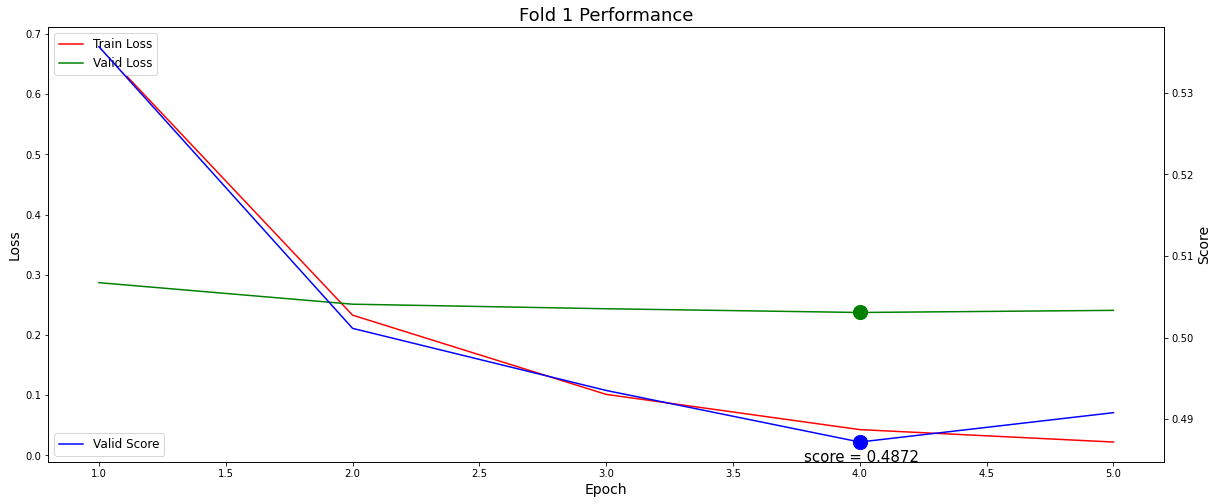

-------------------------------------------------------
REP 1/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6006 | val_loss = 0.3020 | val_score = 0.5496 | 3.20 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2334 | val_loss = 0.2716 | val_score = 0.5211 | 2.52 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1188 | val_loss = 0.2472 | val_score = 0.4972 | 2.13 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0431 | val_loss = 0.2455 | val_score = 0.4955 | 2.15 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0253 | val_loss = 0.2494 | val_score = 0.4994 | 2.27 min
-------------------------------------------------------
Best: score = 0.4955 (epoch 4)
-------------------------------------------------------


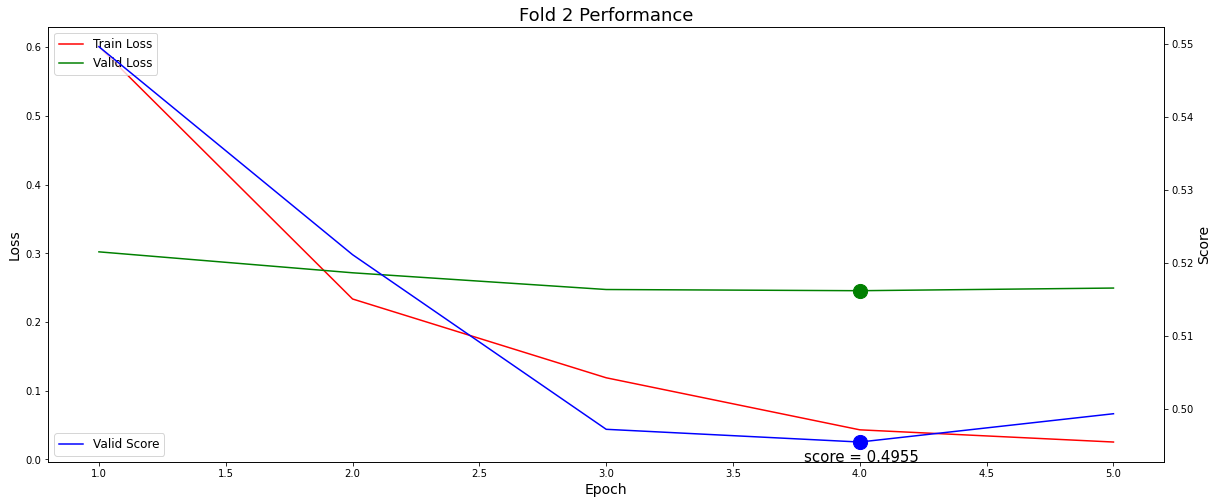

-------------------------------------------------------
REP 1/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.7608 | val_loss = 0.3295 | val_score = 0.5740 | 2.75 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2592 | val_loss = 0.2644 | val_score = 0.5142 | 2.41 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1081 | val_loss = 0.2484 | val_score = 0.4984 | 2.85 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0418 | val_loss = 0.2449 | val_score = 0.4949 | 2.29 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0242 | val_loss = 0.2501 | val_score = 0.5001 | 2.28 min
-------------------------------------------------------
Best: score = 0.4949 (epoch 4)
-------------------------------------------------------


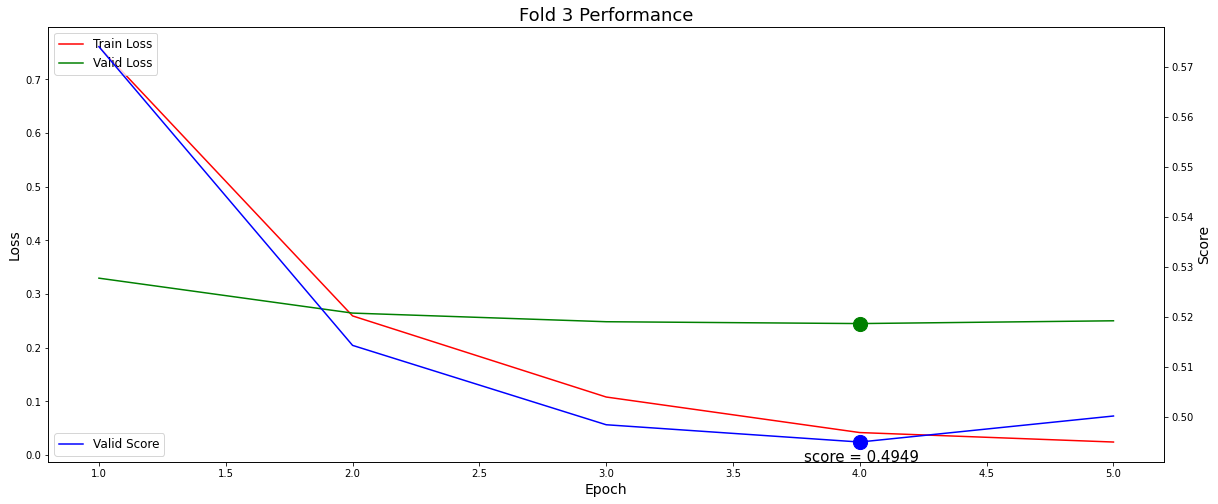

-------------------------------------------------------
REP 1/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6128 | val_loss = 0.3376 | val_score = 0.5811 | 3.24 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2600 | val_loss = 0.2722 | val_score = 0.5217 | 2.86 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1089 | val_loss = 0.2595 | val_score = 0.5094 | 2.23 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0489 | val_loss = 0.2574 | val_score = 0.5073 | 1.98 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0265 | val_loss = 0.2585 | val_score = 0.5085 | 2.07 min
-------------------------------------------------------
Best: score = 0.5073 (epoch 4)
-------------------------------------------------------


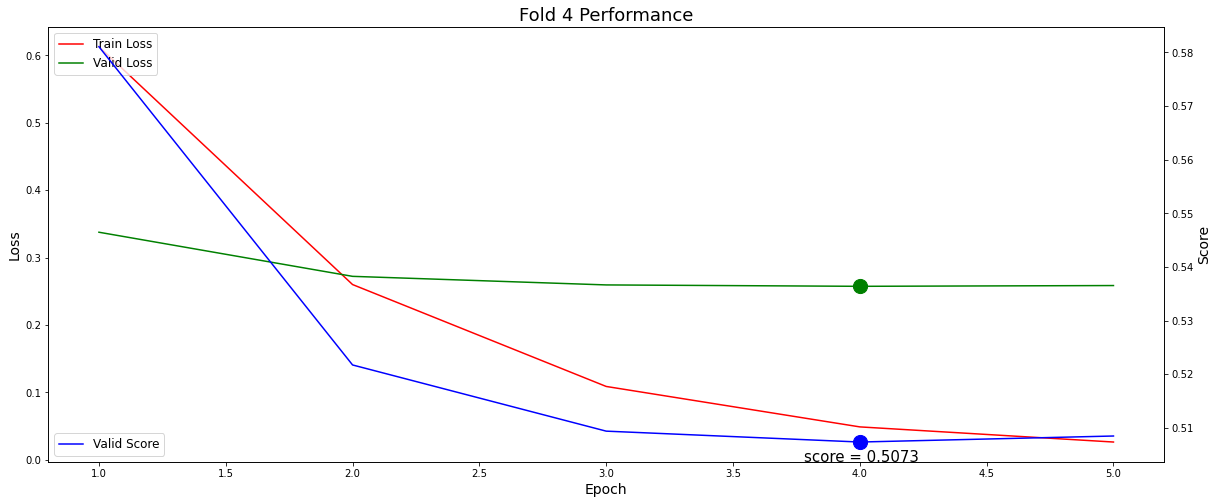

-------------------------------------------------------
REP 1/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6321 | val_loss = 0.3144 | val_score = 0.5607 | 3.24 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2405 | val_loss = 0.2651 | val_score = 0.5149 | 2.81 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1105 | val_loss = 0.2401 | val_score = 0.4900 | 2.93 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0442 | val_loss = 0.2417 | val_score = 0.4916 | 1.80 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0259 | val_loss = 0.2422 | val_score = 0.4921 | 2.09 min
-------------------------------------------------------
Best: score = 0.4900 (epoch 3)
-------------------------------------------------------


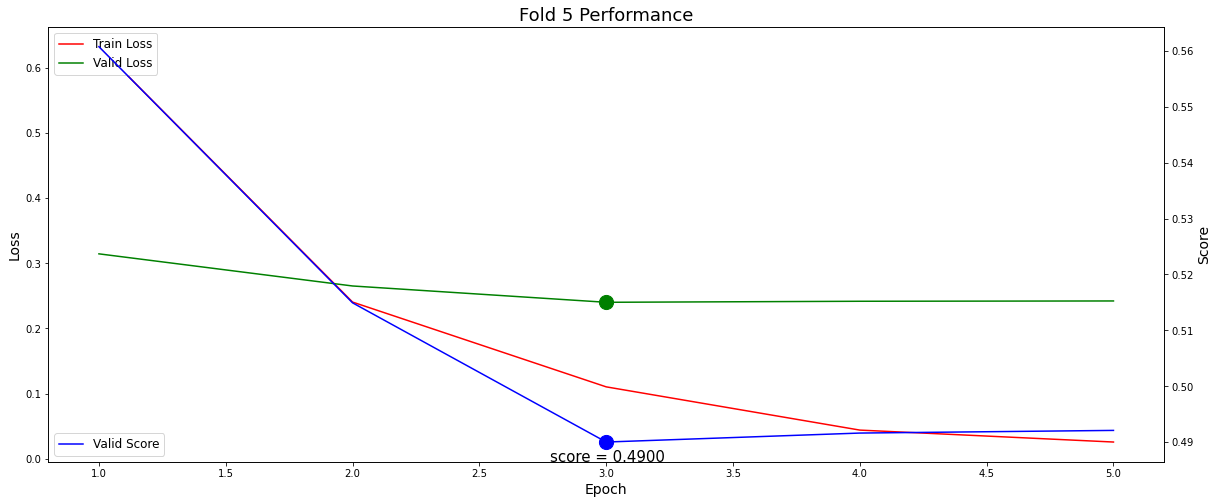

-------------------------------------------------------
REP 1/3 | OOF score = 0.4950
-------------------------------------------------------

-------------------------------------------------------
REP 2/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6384 | val_loss = 0.2916 | val_score = 0.5400 | 3.33 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2211 | val_loss = 0.2501 | val_score = 0.5001 | 2.57 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1108 | val_loss = 0.2354 | val_score = 0.4851 | 2.38 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0425 | val_loss = 0.2368 | val_score = 0.4866 | 2.28 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0237 | val_loss = 0.2409 | val_score = 0.4908 | 2.28 min
-------------------------------------------------------
Best: score = 0.4851 (epoch 3)
-------------------------------------------------------


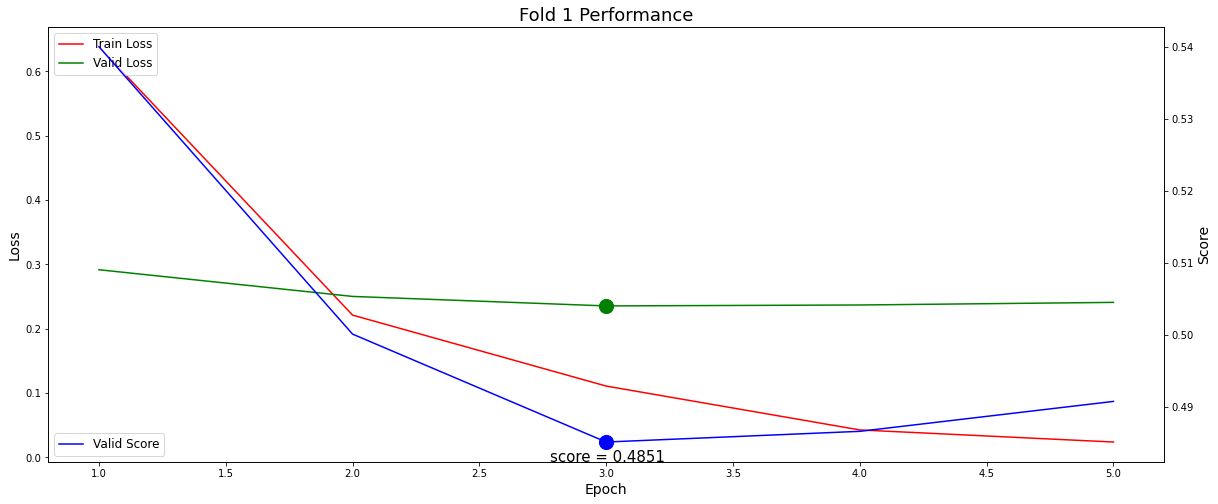

-------------------------------------------------------
REP 2/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6503 | val_loss = 0.3147 | val_score = 0.5610 | 3.11 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2377 | val_loss = 0.2840 | val_score = 0.5330 | 2.58 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0969 | val_loss = 0.2632 | val_score = 0.5130 | 2.15 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0405 | val_loss = 0.2596 | val_score = 0.5095 | 2.49 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0220 | val_loss = 0.2578 | val_score = 0.5078 | 2.15 min
-------------------------------------------------------
Best: score = 0.5078 (epoch 5)
-------------------------------------------------------


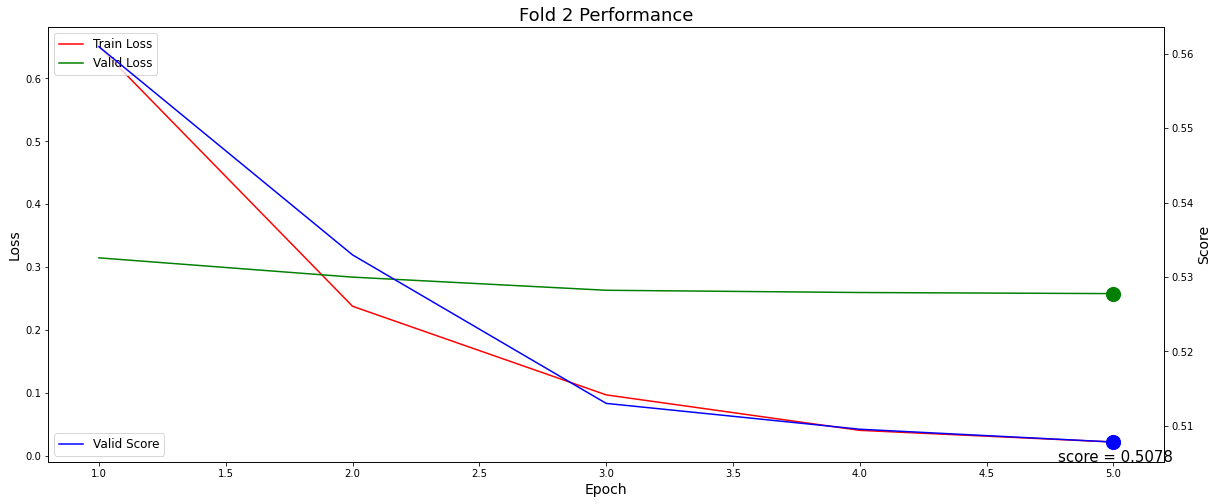

-------------------------------------------------------
REP 2/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.7110 | val_loss = 0.3189 | val_score = 0.5647 | 2.61 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2296 | val_loss = 0.2601 | val_score = 0.5100 | 2.82 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0969 | val_loss = 0.2421 | val_score = 0.4920 | 2.36 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0366 | val_loss = 0.2390 | val_score = 0.4889 | 2.15 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0201 | val_loss = 0.2442 | val_score = 0.4941 | 1.99 min
-------------------------------------------------------
Best: score = 0.4889 (epoch 4)
-------------------------------------------------------


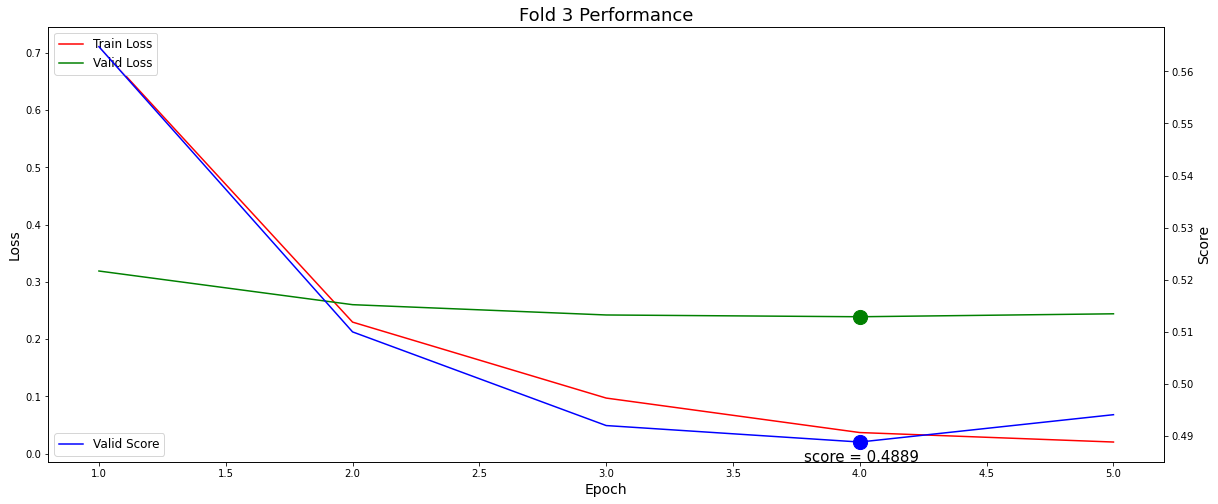

-------------------------------------------------------
REP 2/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5745 | val_loss = 0.3074 | val_score = 0.5544 | 3.37 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2215 | val_loss = 0.2566 | val_score = 0.5066 | 3.01 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0861 | val_loss = 0.2324 | val_score = 0.4820 | 2.66 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0350 | val_loss = 0.2345 | val_score = 0.4842 | 1.96 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0179 | val_loss = 0.2375 | val_score = 0.4873 | 1.56 min
-------------------------------------------------------
Best: score = 0.4820 (epoch 3)
-------------------------------------------------------


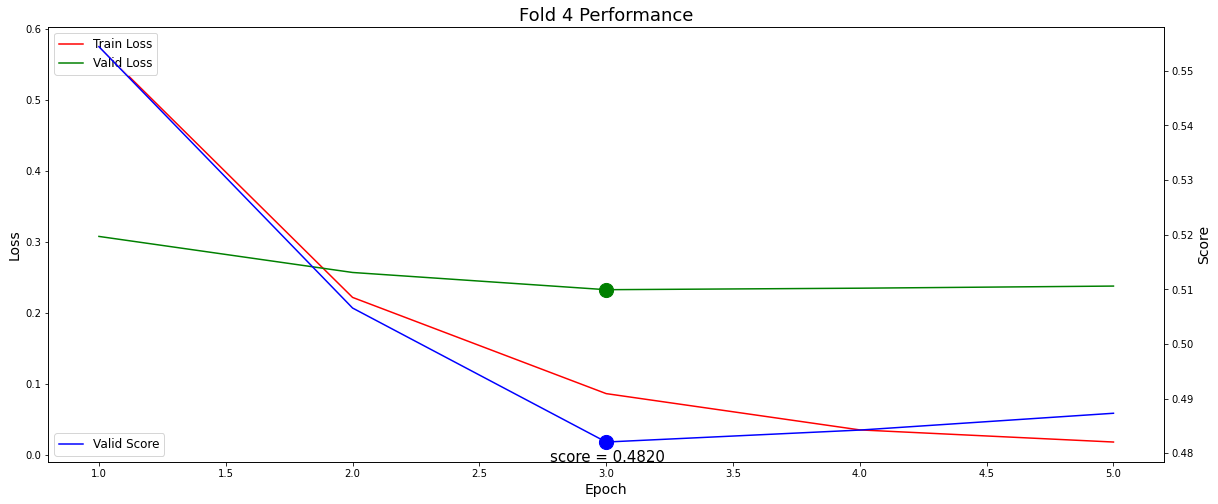

-------------------------------------------------------
REP 2/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6516 | val_loss = 0.2948 | val_score = 0.5430 | 3.18 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2634 | val_loss = 0.2810 | val_score = 0.5301 | 2.36 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1072 | val_loss = 0.2506 | val_score = 0.5006 | 2.71 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0424 | val_loss = 0.2527 | val_score = 0.5027 | 2.08 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0255 | val_loss = 0.2547 | val_score = 0.5047 | 1.89 min
-------------------------------------------------------
Best: score = 0.5006 (epoch 3)
-------------------------------------------------------


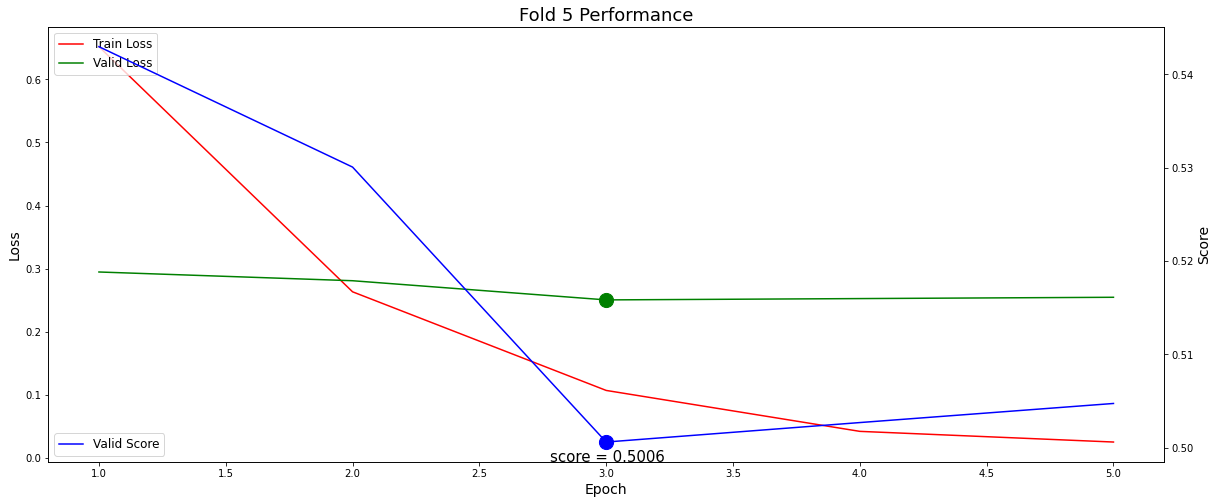

-------------------------------------------------------
REP 2/3 | OOF score = 0.4929
-------------------------------------------------------

-------------------------------------------------------
REP 3/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6514 | val_loss = 0.3238 | val_score = 0.5691 | 3.09 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2435 | val_loss = 0.2683 | val_score = 0.5180 | 2.92 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1193 | val_loss = 0.2392 | val_score = 0.4891 | 2.87 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0433 | val_loss = 0.2410 | val_score = 0.4910 | 2.10 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0254 | val_loss = 0.2483 | val_score = 0.4983 | 2.07 min
-------------------------------------------------------
Best: score = 0.4891 (epoch 3)
-------------------------------------------------------


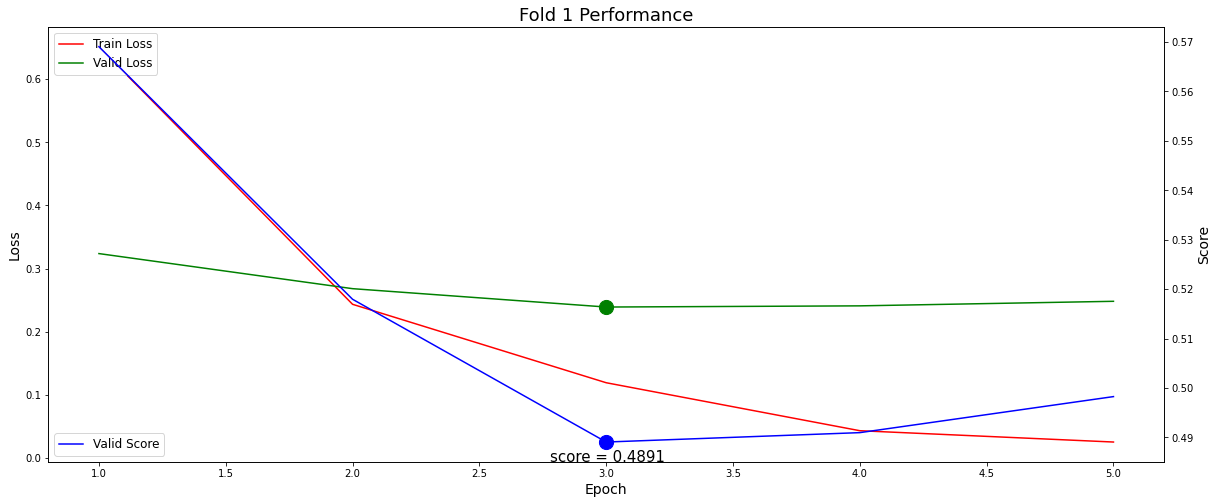

-------------------------------------------------------
REP 3/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5959 | val_loss = 0.2930 | val_score = 0.5413 | 3.29 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2365 | val_loss = 0.2536 | val_score = 0.5035 | 2.46 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0983 | val_loss = 0.2360 | val_score = 0.4858 | 1.82 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0350 | val_loss = 0.2365 | val_score = 0.4863 | 2.01 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0200 | val_loss = 0.2407 | val_score = 0.4906 | 1.98 min
-------------------------------------------------------
Best: score = 0.4858 (epoch 3)
-------------------------------------------------------


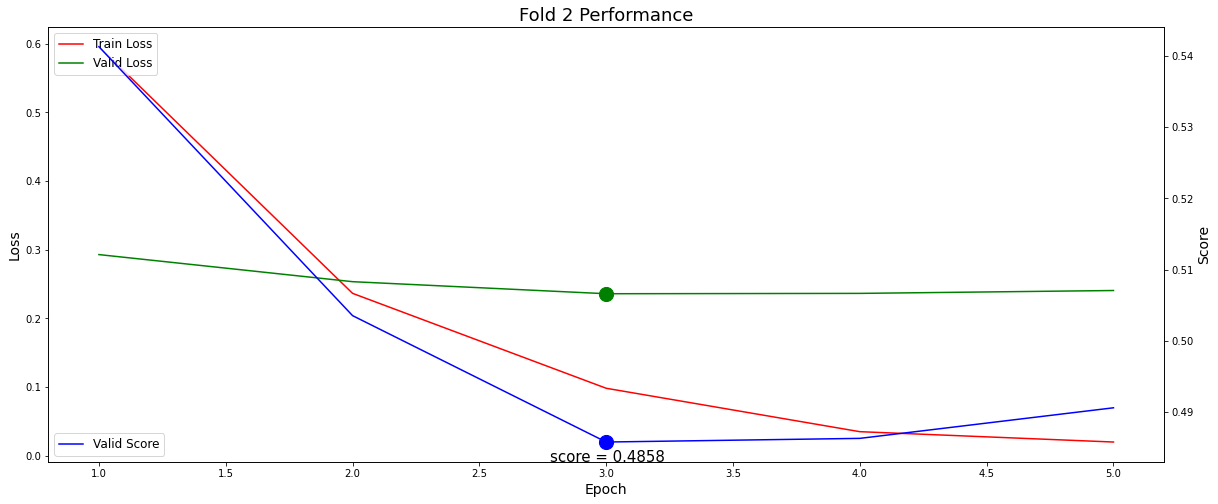

-------------------------------------------------------
REP 3/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6967 | val_loss = 0.3065 | val_score = 0.5536 | 3.34 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2680 | val_loss = 0.2440 | val_score = 0.4940 | 2.86 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1061 | val_loss = 0.2390 | val_score = 0.4888 | 2.41 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0469 | val_loss = 0.2320 | val_score = 0.4816 | 2.43 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0265 | val_loss = 0.2380 | val_score = 0.4878 | 2.08 min
-------------------------------------------------------
Best: score = 0.4816 (epoch 4)
-------------------------------------------------------


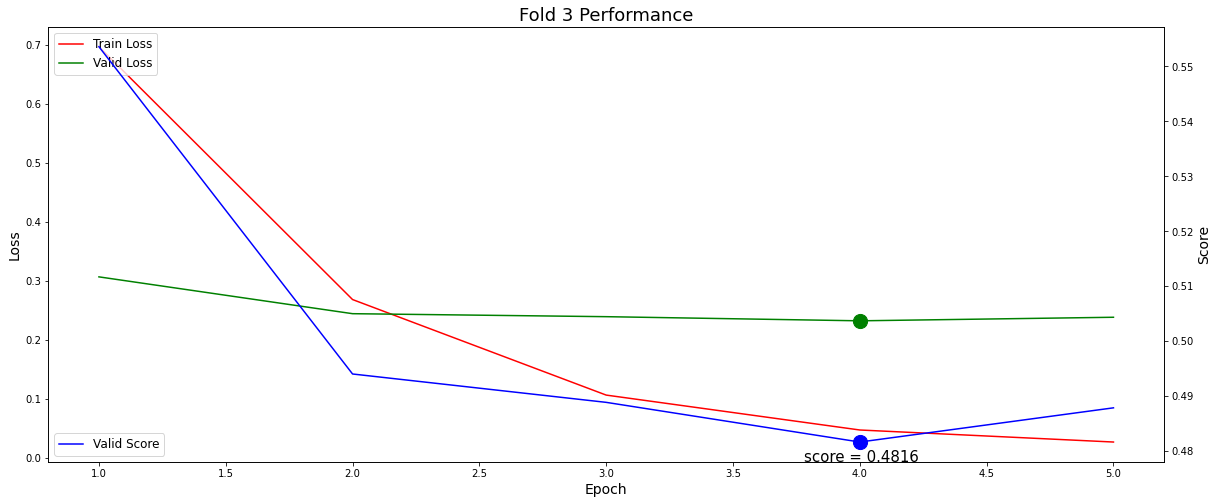

-------------------------------------------------------
REP 3/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6145 | val_loss = 0.3119 | val_score = 0.5585 | 3.11 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2283 | val_loss = 0.2550 | val_score = 0.5050 | 2.97 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1015 | val_loss = 0.2404 | val_score = 0.4904 | 2.68 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0433 | val_loss = 0.2367 | val_score = 0.4865 | 2.46 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0236 | val_loss = 0.2367 | val_score = 0.4865 | 1.81 min
-------------------------------------------------------
Best: score = 0.4865 (epoch 4)
-------------------------------------------------------


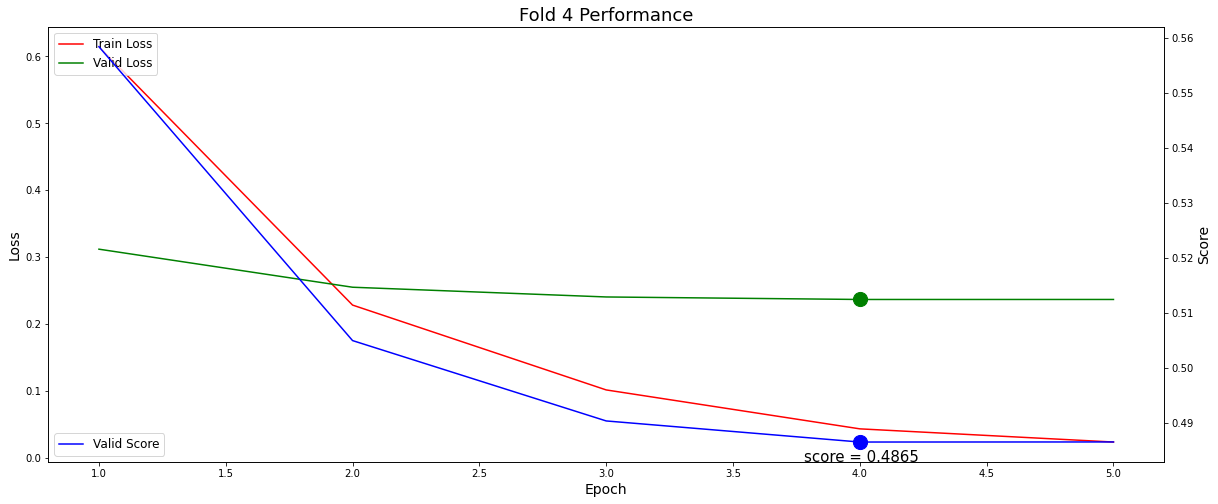

-------------------------------------------------------
REP 3/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6301 | val_loss = 0.3215 | val_score = 0.5670 | 3.33 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2265 | val_loss = 0.2597 | val_score = 0.5096 | 2.86 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0976 | val_loss = 0.2501 | val_score = 0.5001 | 2.31 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0398 | val_loss = 0.2497 | val_score = 0.4997 | 2.29 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0231 | val_loss = 0.2514 | val_score = 0.5014 | 2.08 min
-------------------------------------------------------
Best: score = 0.4997 (epoch 4)
-------------------------------------------------------


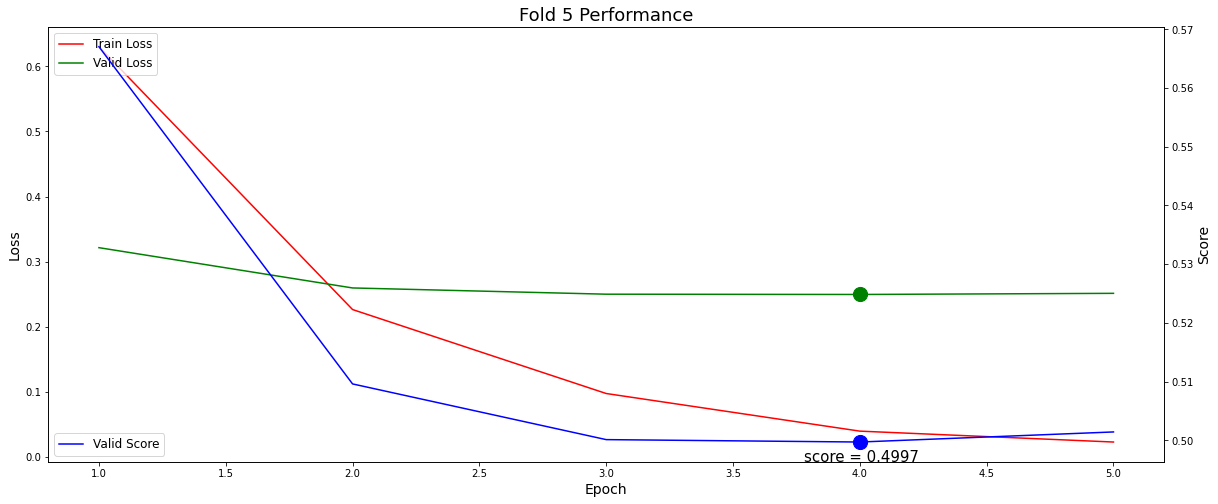

-------------------------------------------------------
REP 3/3 | OOF score = 0.4885
-------------------------------------------------------

-------------------------------------------------------
Mean OOF score = 0.4921
-------------------------------------------------------

Finished in 186.17 minutes


In [12]:
####### CROSS-VALIDATION LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_training,
                  args          = (df, CFG),
                  num_processes = CFG['num_devices'],
                  use_fp16      = CFG['use_fp16'])

# clear memory
gc.collect()
torch.cuda.empty_cache()

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

# 5. INFERENCE

In [13]:
####### INFERENCE LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_inference,
                  args          = (df, sub, CFG),
                  num_processes = 1,
                  use_fp16      = CFG['use_fp16'])

# clear memory
gc.collect()
torch.cuda.empty_cache()

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
REP 1/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Finished in 5.12 minutes


In [14]:
####### CHECK OOF PERFORMANCE

# import OOF
oof = pd.read_csv(CFG['out_path'] + 'oof.csv')

# compute score
oof_score = []
for rep in range(CFG['num_reps']):
    oof_score.append(get_score(oof['target'], oof['pred_rep' + str(rep)]))
CFG['oof_score'] = np.mean(oof_score)

# compute bag score
blend = 'amean'
oof['blend']     = compute_blend(oof, ['pred_rep' + str(rep) for rep in range(CFG['num_reps'])], blend, CFG)
CFG['bag_score'] = get_score(oof['target'], oof['blend'])

# print performance
print('-' * 22)
print('OOF score     = {:.4f}'.format(CFG['oof_score']))
print('OOF bag score = {:.4f}'.format(CFG['bag_score']))
print('-' * 22)

----------------------
OOF score     = 0.4922
OOF bag score = 0.4840
----------------------


In [15]:
####### EXPORT CONFIGURATION

# save dictionary
pickle.dump(CFG, open(CFG['out_path'] + 'configuration.pkl', 'wb'))

# send data to Neptune
if CFG['tracking']:
    neptune.send_metric('oof_score', CFG['oof_score'])
    neptune.send_metric('bag_score', CFG['bag_score'])
    neptune.send_artifact(CFG['out_path'] + 'configuration.pkl')
    neptune.stop()